In [1]:
import os
os.environ['FOR_DISABLE_CONSOLE_CTRL_HANDLER'] = '1'

import random, statistics
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import dill, joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torchinfo

from monai.losses.dice import DiceLoss, DiceFocalLoss, GeneralizedDiceFocalLoss
from monai.metrics import MeanIoU, SurfaceDiceMetric, DiceHelper # type:ignore
from schedulefree import AdamWScheduleFree
from came_pytorch import CAME
from madgrad import MADGRAD

from stuff.found.focal_tversky_loss import focal_tversky

from glio.train2 import *
from glio.train2.cbs_summary import Summary
from glio.visualize import vis_imshow, vis_imshow_grid, Visualizer
from glio.plot.figure import Figure, qimshow, qimshow_batch, qlinechart, qpath10d, qpath2d
from glio.jupyter_tools import show_slices, show_slices_arr, clean_mem
from glio.torch_tools import area_around, one_hot_mask, summary, lr_finder, to_binary, count_parameters
from glio.python_tools import type_str, CacheRepeatIterator, get_all_files, get0, get1
from glio import nn as gnn
from glio.nn import conv, convt, linear, seq, block
from glio.data import DSToTarget
from glio.helpers import cnn_output_size, tcnn_output_size
from glio.loaders import nifti
from glio.transforms import fToChannels, fToChannelsFirst,fToChannelsLast, z_normalize, norm_to01
from glio.datasets.BRaTS2024_preloaded import get_ds_2d, get_ds_around, loader_2d, loader_around, loader_around_fix

from glio.specific.brats import plot_preds


d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
TITLE = "BRATS2024 2D general"
bratstrain = get_ds_around(r"E:\dataset\BRaTS2024-GoAT\train hist.joblib")
bratstest = get_ds_around(r"E:\dataset\BRaTS2024-GoAT\test hist.joblib")

dstrain = DSToTarget()
dstest = DSToTarget()
dstrain.add_samples(bratstrain, loader_around_fix, None, get0, get1)
dstest.add_samples(bratstest, loader_around_fix, None, get0, get1)



In [3]:
show_slices(dstrain[0][0])

interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=5, description='s0', max=11)…

<function glio.jupyter_tools.show_slices.<locals>.f(color, **kwargs)>

In [4]:
from monai.networks.nets import SwinUNETR # type:ignore
summary(SwinUNETR(img_size=(96,96),in_channels=12, out_channels=4, spatial_dims = 2), (8,12,96,96))

path                                         module                                       input size               output size              params    buffers   
monai.networks.nets.swin_unetr.SwinUNETR/swinViT/patch_embed/projtorch.nn.modules.conv.Conv2d                 (8, 12, 96, 96)          (8, 24, 48, 48)          1176      0         
monai.networks.nets.swin_unetr.SwinUNETR/swinViT/pos_droptorch.nn.modules.dropout.Dropout             (8, 24, 48, 48)          (8, 24, 48, 48)          0         0         
monai.networks.nets.swin_unetr.SwinUNETR/swinViT/layers1/0/blocks/0/norm1torch.nn.modules.normalization.LayerNorm     (8, 48, 48, 24)          (8, 48, 48, 24)          48        0         
monai.networks.nets.swin_unetr.SwinUNETR/swinViT/layers1/0/blocks/0/attn/qkvtorch.nn.modules.linear.Linear               (392, 49, 24)            (392, 49, 72)            1800      0         
monai.networks.nets.swin_unetr.SwinUNETR/swinViT/layers1/0/blocks/0/attn/softmaxtorch.nn.modules.activat

[0.003, 0.113, -0.157, 0.002, 0.189, -0.021, -0.018, -0.045, 0.049, 0.074, -0.021, -0.014, 0.023, 0.061, 0.017, 0.014, -0.064, 0.128, -0.053, -0.021, 0.061, -0.005, -0.057, 0.108, 0.001, -0.01, -0.181, 0.159, -0.016, 0.062, -0.094, -0.08, -0.001], [0.894, 0.918, 1.006, 0.965, 0.992, 0.998, 1.007, 1.0, 1.002, 0.997, 0.998, 1.002, 0.994, 1.003, 0.998, 0.998, 0.999, 0.998, 1.001, 0.999, 0.999, 1.006, 1.001, 1.003, 0.998, 0.994, 0.996, 1.003, 1.001, 0.999, 1.002, 1.003, 1.003], [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]          


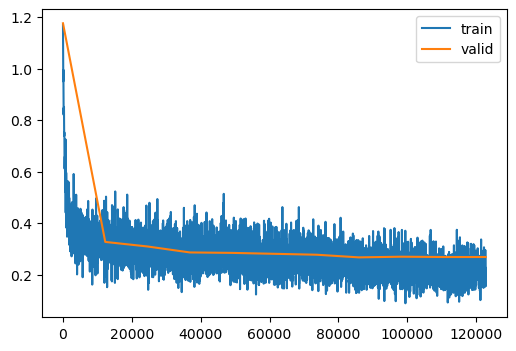

test loss: min: 0.2676; max: 1.1765; last: 0.2690
test accuracy: min: 0.6064; max: 0.9785; last: 0.9783
test iou: min: 0.4683; max: 0.9660; last: 0.9660
test precision: min: 0.6155; max: 0.9793; last: 0.9793
test recall: min: 0.6155; max: 0.9793; last: 0.9793
test f1: min: 0.6093; max: 0.9787; last: 0.9787
test average precision: min: 0.2486; max: 0.3976; last: 0.3749
test roc auc: min: 0.5043; max: 0.7679; last: 0.7395
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0062; last: 0.0000
grad std: min: 0.0000; max: 0.0008; last: 0.0000
grad-update mean: min: 0.0000; max: 0.0007; last: 0.0000
grad-update angle: min: 1.5539; max: 1.5915; last: 1.5701
param mean: min: -0.0202; max: 0.0004; last: -0.0174
param var: min: 0.0019; max: 0.0640; last: 0.0478
param min: min: -3.7262; max: -2.0909; last: -3.3021
param max: min: 2.0949; max: 6.1202; last: 4.8555
time: min: 350.9034; max: 36897.9678; last: 36897.9678
lr: min: 0.0000; max: 0.0030; last: 0.0000
trai

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


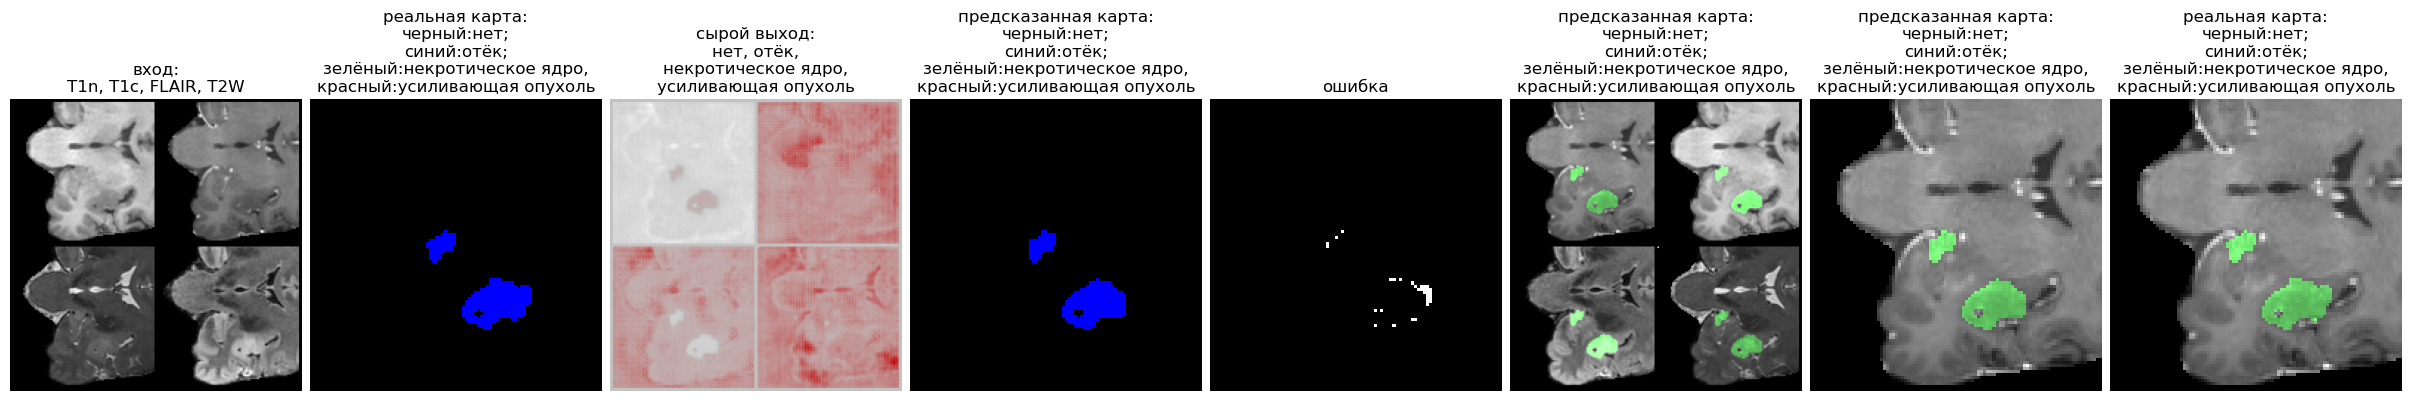

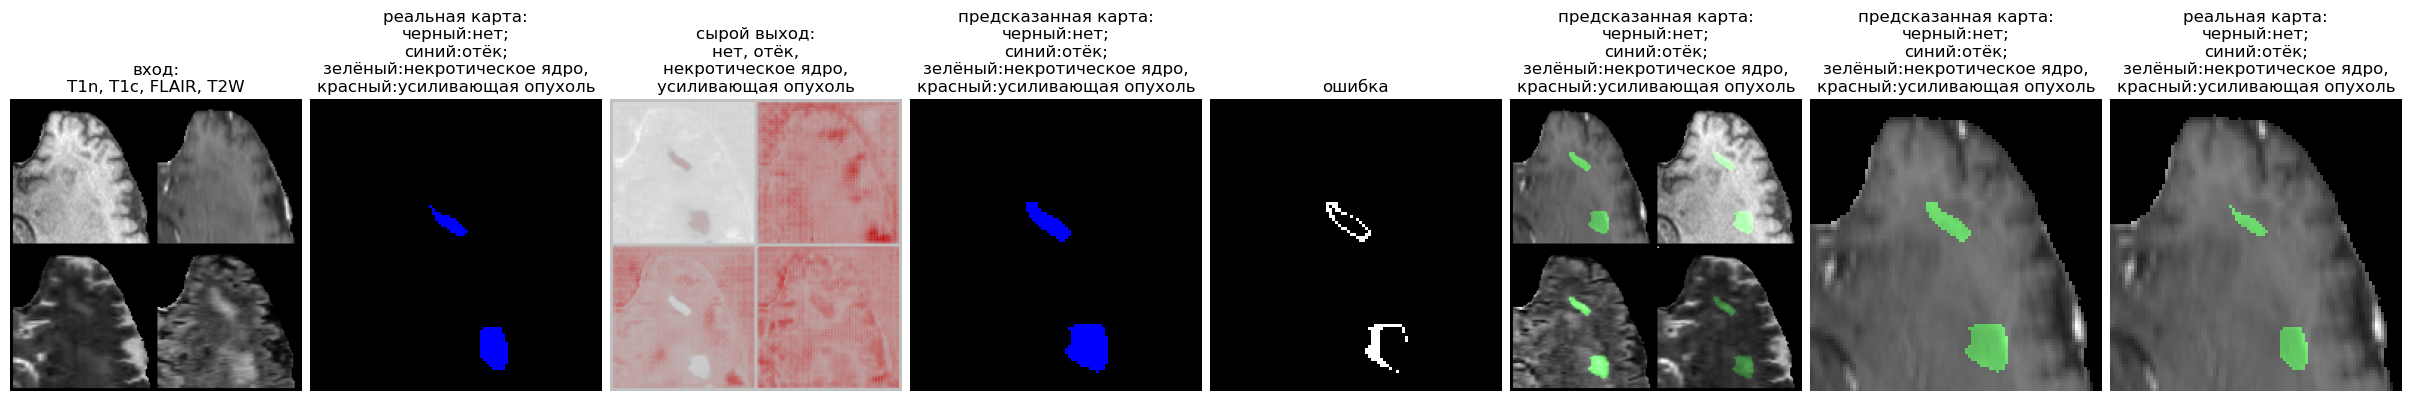

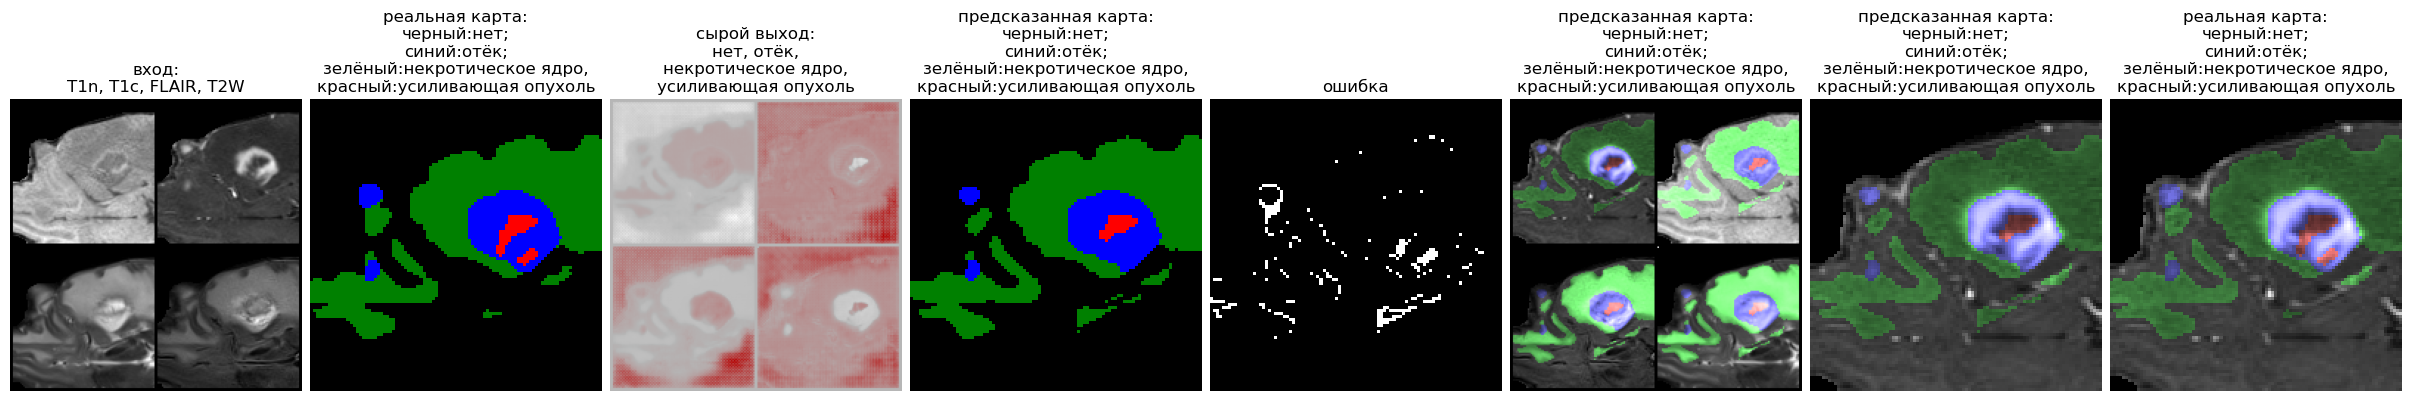

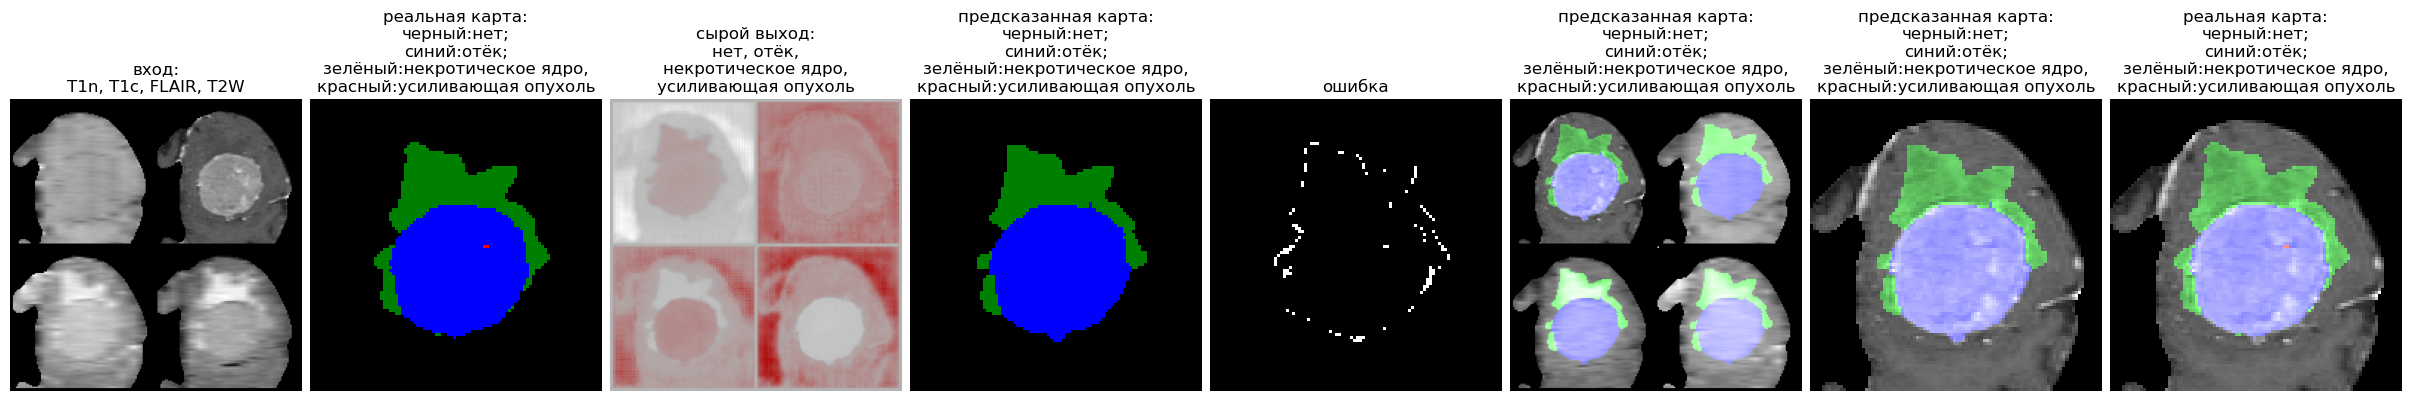

In [5]:
MODEL = SwinUNETR(img_size=(96,96),in_channels=12, out_channels=4, spatial_dims = 2)
NAME = f"{MODEL.__class__.__name__}"
LR = 3e-3
BATCH_SIZE = 24
N_EPOCHS = 10

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = optim.AdamW(MODEL.parameters(), lr=LR, eps=1e-8)
LOSS_FN = GeneralizedDiceFocalLoss(softmax=True)
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=N_EPOCHS)

clean_mem()
MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16), Log_LastGradsAngle(128), Log_GradPath(1)
              Log_UpdateDist(128), Log_GradDist(128), Log_GradUpdateAngle(128), Log_ParamDist(128),
              Log_LastUpdatesAngle(128),
              Log_ParamPath(1), Log_UpdatePath(1),
              Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), PerformanceTweaks(True), Accelerate("no"),
              Metric_Accuracy(True, True, False, name = 'accuracy', step=4),
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_Precision(4, True, True, step=16),
              Torcheval_Recall(4, True, True, step=16),
              Torcheval_Dice(4, True, True, step=8, name='f1'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              FastProgressBar(step_batch=128, plot=True),
              Summary(),
              PlotSummary(),
              )

LEARNER_NAME = f"brats-hist-around1 32 {NAME} AdamW3e-3 onecycle eps3e-6 GDiceFocalLoss 2"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest)
plt.show()
plot_preds(learner, dstrain[200])
plot_preds(learner, dstest[500])
plot_preds(learner, dstrain[1650])
plot_preds(learner, dstest[1650])

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


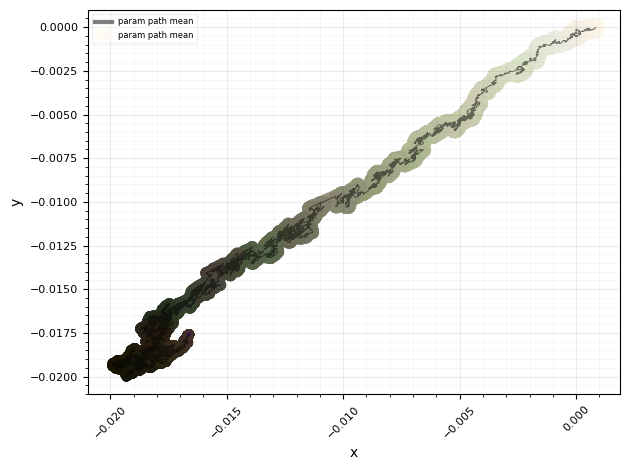

In [6]:
learner.logger.path10d("param path mean")